## WORKSHOP 2: PREDICCIÓN DE PRECIO EN DOLARES

<a id="section_toc"></a> 

## INDICE

[Intro](#section_intro)

[Elección del espacio geográfico a elegir](#section_dataset)

[Modelo de predicción](#section_modelo)

[Train-Test-Split](#section_traintestsplit)

[Instanciar el modelo](#section_instanciar)

[Cálculo de métricas de error para Train](#section_r2_train)

[Análisis de p-value para las variables predictoras](#section_stats)

[Gráfico de la predicción](#section_graf)

[Cálculo de métricas de error (Test)](#section_test_metrics)

[Regression Ridge](#section_ridge)

$\hspace{.5cm}$[Normalización](#section_norm)

$\hspace{.5cm}$[Train-Test Split Normalized](#section_train_test_norm)

$\hspace{.5cm}$[Fit Regression with Regularization and Cross_Validation](#section_fit_ridge)

$\hspace{.5cm}$[Metricas de Error (Train)](#section_error_ridge_train)

$\hspace{.5cm}$[Gráfico de la predicción](#section_graf_ridge)

$\hspace{.5cm}$[Metricas de Error (Test)](#section_error_ridge_test)

[Lasso](#section_lasso)

$\hspace{.5cm}$[Train Test Split](#section_lasso_train_test_split)

$\hspace{.5cm}$[Fit model with Cross Validation](#section_lasso_fit)

$\hspace{.5cm}$[Métricas de Error (Train)](#section_lasso_error_train)

$\hspace{.5cm}$[Gráfico de la predicción](#section_graf_lasso)

$\hspace{.5cm}$[Metricas de Error (Test)](#section_error_ridge_test)


















<a id="section_intro"></a> 
## Intro

[volver a TOC](#section_toc)

En primer instancia, se cargan las bibliotecas a utilizar. Luego se cargará el dataset y se realizará una primer análisis para definir en qué espacio geográfico se realizará el modelo de predicción

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data_clean.csv')
data.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,Country/Barrio_Cerrado,geometry,CiudadClean,es_country_clean,amenities,m2 Totales,m2 cubiertos,rooms_regex,precio_por_m2_total,precio_por_m2_cubiertos
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,NaN,POINT (-58.5088387 -34.6618237),mataderos,no,no,55.0,40.0,2 AMB,1127.272727,1550.000000
1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,NaN,POINT (-58.5229825 -34.6522615),mataderos,no,no,55.0,55.0,2 AMB,1309.090909,1309.090909
2,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,NaN,POINT (-57.5494468 -38.0026256),mar del plata,no,no,35.0,35.0,NaN,1828.571429,1828.571429
3,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,...,NaN,POINT (-58.52178249999999 -34.53295670000001),vicente lópez,no,no,106.0,78.0,NaN,1226.415094,1666.666667
4,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,NaN,POINT (-58.443362 -34.5598729),belgrano,no,no,45.0,40.0,NaN,3066.666667,3450.000000


<a id="section_dataset"></a> 
## Elección del espacio geográfico a predecir

[volver a TOC](#section_toc)

Lo primero que se hace es analizar el porcentaje de datos que hay en el dataset en función de las provincias.

In [4]:
state = data.state_name.value_counts()

state_df = pd.DataFrame(state)

state_df

,state_name
Capital Federal,26658
Bs.As. G.B.A. Zona Norte,22440
Bs.As. G.B.A. Zona Sur,9985
Buenos Aires Costa Atlántica,7799
Bs.As. G.B.A. Zona Oeste,6204
Córdoba,4837
Santa Fe,4806
Buenos Aires Interior,1381
Corrientes,436
Mendoza,337


In [5]:
state_df = state_df.rename_axis('index').reset_index()

In [6]:
state_df_2 = state_df.iloc[:11]

state_df_2

,index,state_name
0,Capital Federal,26658
1,Bs.As. G.B.A. Zona Norte,22440
2,Bs.As. G.B.A. Zona Sur,9985
3,Buenos Aires Costa Atlántica,7799
4,Bs.As. G.B.A. Zona Oeste,6204
5,Córdoba,4837
6,Santa Fe,4806
7,Buenos Aires Interior,1381
8,Corrientes,436
9,Mendoza,337


Se puede observar la mayor concentración de los datos se ven en Capital Federal y Buenos Aires. Para ser más claro esto, se graficará el porcentaje de los datos de las 11 provincias o espacios geográficos con mayor cantidad de datos.

In [7]:
state_df_2['value'] = state_df_2.state_name.apply(lambda x: (x/data.shape[0])*100)

state_df_2

<ipython-input-7-e99c3d3f4c62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df_2['value'] = state_df_2.state_name.apply(lambda x: (x/data.shape[0])*100)


,index,state_name,value
0,Capital Federal,26658,30.864169
1,Bs.As. G.B.A. Zona Norte,22440,25.980642
2,Bs.As. G.B.A. Zona Sur,9985,11.560459
3,Buenos Aires Costa Atlántica,7799,9.029547
4,Bs.As. G.B.A. Zona Oeste,6204,7.182883
5,Córdoba,4837,5.600195
6,Santa Fe,4806,5.564303
7,Buenos Aires Interior,1381,1.598898
8,Corrientes,436,0.504793
9,Mendoza,337,0.390173


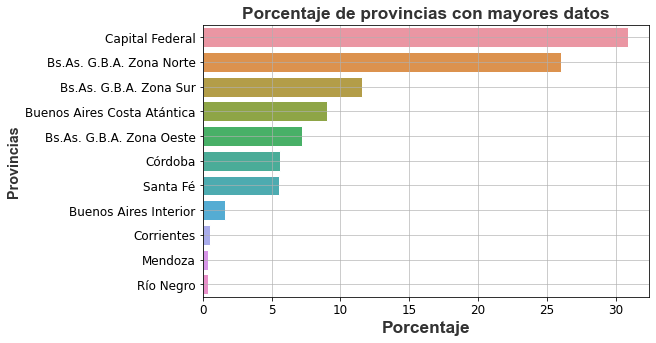

In [8]:
dims = (8,5)
fig,ax = plt.subplots(figsize=dims)#,ncols=2
with sns.axes_style('darkgrid'):
    g = sns.barplot(x ='value',y = 'index',data=state_df_2,
                     ax=ax)  #style='sort' linewidth=2.3,markers=True,markersize=9
    g.set_xlabel('Porcentaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Provincias',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Porcentaje de provincias con mayores datos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_xticks([0,5,10,15,20,25,30])
    g.set_xticklabels(['0','5','10','15','20','25','30'],size=12)
    g.set_yticklabels(['Capital Federal','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur','Buenos Aires Costa Atántica'
                       ,'Bs.As. G.B.A. Zona Oeste','Córdoba','Santa Fé','Buenos Aires Interior','Corrientes',
                       'Mendoza','Río Negro'],size=12)
    #g.legend() #bbox_to_anchor=(0.99, 0.32)
    g.grid(alpha=0.8)

En este gráfico, puede verse que el aproximadamente el 31 % de los datos del dataset son de Capital Federal y el 26% Bs. As. GBA Zona Norte (aproximadamente). Dando en estos 2 espacios geográficos más del 50 % de los datos del dataset. Es por esto, que el modelo de predicción se centrará en Capital Federal y Bs. As. GBA Zona Norte

In [9]:
mask = np.logical_or(data.state_name == 'Capital Federal',data.state_name == 'Bs.As. G.B.A. Zona Norte')

data2 = data[mask]

data2.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,Country/Barrio_Cerrado,geometry,CiudadClean,es_country_clean,amenities,m2 Totales,m2 cubiertos,rooms_regex,precio_por_m2_total,precio_por_m2_cubiertos
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,NaN,POINT (-58.5088387 -34.6618237),mataderos,no,no,55.0,40.0,2 AMB,1127.272727,1550.000000
1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,NaN,POINT (-58.5229825 -34.6522615),mataderos,no,no,55.0,55.0,2 AMB,1309.090909,1309.090909
3,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,...,NaN,POINT (-58.52178249999999 -34.53295670000001),vicente lópez,no,no,106.0,78.0,NaN,1226.415094,1666.666667
4,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,NaN,POINT (-58.443362 -34.5598729),belgrano,no,no,45.0,40.0,NaN,3066.666667,3450.000000
5,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,NaN,POINT (-58.443362 -34.5598729),belgrano,no,no,65.0,60.0,NaN,3000.000000,3250.000000


A su vez, existe la columna property_type o tipo de propiedad que está conformada por PH, apartment, house y store. A continuación, se que se hará es observar el porcentaje de estas propiedades para las provincias elegidas.

In [10]:
data_state_group = data2.pivot_table(data2, index=['state_name', 'property_type'],aggfunc = 'count')

data_state_group

Barrio_Zona_Country  CiudadClean  \
state_name               property_type                                     
Bs.As. G.B.A. Zona Norte PH                             762          895   
                         apartment                     7329         9368   
                         house                         7485        11731   
                         store                          316          446   
Capital Federal          PH                              52         1659   
                         apartment                     1079        22664   
                         house                          116         1357   
                         store                           65          978   

                                        Country/Barrio_Cerrado  Unnamed: 0  \
state_name               property_type                                       
Bs.As. G.B.A. Zona Norte PH                                  0         895   
                         apartment                         314        9368   
                         house                             221       11731   
                         store                               1         446   
Capital Federal          PH                                  0        1659   
                         apartment                           0       22664   
                         house                               0        1357   
                         store                               0         978   

                                        amenities  country_name  currency  \
state_name               property_type                                      
Bs.As. G.B.A. Zona Norte PH                   895           895       895   
                         apartment           9368          9368      9368   
                         house              11731         11731     11731   
                         store                446           446       446   
Capital Federal          PH                  1659          1659      1659   
                         apartment          22664         22664     22664   
                         house               1357          1357      1357   
                         store                978           978       978   

                                        description  es_country_clean  \
state_name               property_type                                  
Bs.As. G.B.A. Zona Norte PH                     895               895   
                         apartment             9367              9368   
                         house                11731             11731   
                         store                  446               446   
Capital Federal          PH                    1659              1659   
                         apartment            22664             22664   
                         house                 1357              1357   
                         store                  978               978   

                                        expenses  ...  place_name  \
state_name               property_type            ...               
Bs.As. G.B.A. Zona Norte PH                   42  ...         895   
                         apartment          1471  ...        9367   
                         house              1237  ...       11710   
                         store                61  ...         446   
Capital Federal          PH                  176  ...        1659   
                         apartment          5816  ...       22664   
                         house                10  ...        1357   
                         store               160  ...         978   

                                        place_with_parent_names  \
state_name               property_type                            
Bs.As. G.B.A. Zona Norte PH                                 895   
                         apartment                         9368   
                         house       

In [11]:
data_pivot = data_state_group.loc[:,['CiudadClean']]

data_pivot

CiudadClean
state_name               property_type             
Bs.As. G.B.A. Zona Norte PH                     895
                         apartment             9368
                         house                11731
                         store                  446
Capital Federal          PH                    1659
                         apartment            22664
                         house                 1357
                         store                  978

Para analizar esto último, se utiliza una tabla pivot y se calcula los porcentajes en función de la cantidad de datos de Capital Federal y Bs. As. GBA Zona Norte

In [12]:
BS_total = np.sum(data_pivot.CiudadClean.iloc[:4])

CF_total = np.sum(data_pivot.CiudadClean.iloc[4:])

data_pivot['porcentaje'] = [(data_pivot.CiudadClean.iloc[i]/BS_total)*100 if i < 4 else (data_pivot.CiudadClean.iloc[i]/CF_total)*100 for i in range(0,8)]


data_pivot

CiudadClean  porcentaje
state_name               property_type                         
Bs.As. G.B.A. Zona Norte PH                     895    3.988414
                         apartment             9368   41.746881
                         house                11731   52.277184
                         store                  446    1.987522
Capital Federal          PH                    1659    6.223273
                         apartment            22664   85.017631
                         house                 1357    5.090404
                         store                  978    3.668692

In [13]:
data_pivot = data_pivot.reset_index(level=[0,1])
data_pivot.columns = ['_'.join(col) for col in data_pivot.columns.values]

In [14]:
columns = ['state_name','property_type','ciudad_clean','porcentaje']
data_pivot.columns = columns

In [15]:
data_pivot.head()

,state_name,property_type,ciudad_clean,porcentaje
0,Bs.As. G.B.A. Zona Norte,PH,895,3.988414
1,Bs.As. G.B.A. Zona Norte,apartment,9368,41.746881
2,Bs.As. G.B.A. Zona Norte,house,11731,52.277184
3,Bs.As. G.B.A. Zona Norte,store,446,1.987522
4,Capital Federal,PH,1659,6.223273


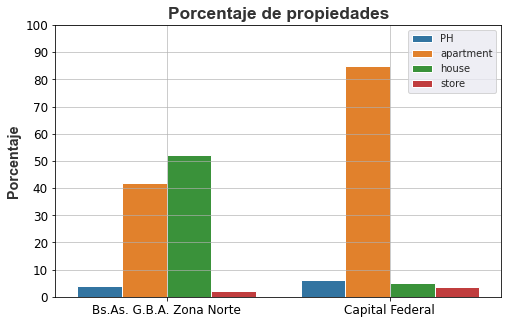

In [16]:
dims = (8,5)
fig,ax = plt.subplots(figsize=dims)#,ncols=2
with sns.axes_style('darkgrid'):
    g = sns.barplot(x ='state_name',y = 'porcentaje',hue='property_type',data=data_pivot,
                     ax=ax)  #style='sort' linewidth=2.3,markers=True,markersize=9
    g.set_xlabel('',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Porcentaje',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_title('Porcentaje de propiedades',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
    g.set_xticklabels(['Bs.As. G.B.A. Zona Norte','Capital Federal'],size=12)
    g.set_yticklabels(['0','10','20','30','40','50','60','70','80','90','100'],size=12)
    g.legend() #bbox_to_anchor=(0.99, 0.32)
    g.grid(alpha=0.8)

En este gráfico, puede verse que para Capital Federal, el 85 % de los datos son de apartment, y para Bs. As. Zona Norte, praticamente el 90 % de los datos está concentrado en apartment y house, con una cantidad de porcentaje de datos muy similar.
Es por esto, que el modelo que se elije para predecir será el precio en dolares de Capital Federal y Bs. As. BGA Zona norte, para aprtments de Capital Federal y apartment y house de Bs. As. GBA Zona Norte.

<a id="section_modelo"></a> 
## Modelo de predicción

[volver a TOC](#section_toc)

En primer instancia, se crea una nueva variable predictora proporción cubierto (prop_cubierto) y código y código2 para luego realizar el filtrado correspondiente y limpieza de outlier.
La variable código se utilizará para filtrar por espacio geográfico y tipo de propiedad (2 en 1) y la variable código2 para limpieza de outlier agrupando por provincia, propiedad, amenities y country.

PD: No había presupuesto para hacer esto por groupby o pivot_table :(

In [17]:
data.property_type = data.property_type.apply(str)
data.state_name = data.state_name.apply(str)

data['codigo'] = data['property_type'] + data['state_name']
data['codigo2'] = data.property_type + data.state_name + data.amenities + data.es_country_clean
data['prop_cubierto'] = data['m2 cubiertos']/data['m2 Totales']
data.head()

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,es_country_clean,amenities,m2 Totales,m2 cubiertos,rooms_regex,precio_por_m2_total,precio_por_m2_cubiertos,codigo,codigo2,prop_cubierto
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,no,no,55.0,40.0,2 AMB,1127.272727,1550.000000,PHCapital Federal,PHCapital Federalnono,0.727273
1,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,no,no,55.0,55.0,2 AMB,1309.090909,1309.090909,apartmentCapital Federal,apartmentCapital Federalnono,1.000000
2,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,no,no,35.0,35.0,NaN,1828.571429,1828.571429,apartmentBuenos Aires Costa Atlántica,apartmentBuenos Aires Costa Atlánticanono,1.000000
3,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,...,no,no,106.0,78.0,NaN,1226.415094,1666.666667,PHBs.As. G.B.A. Zona Norte,PHBs.As. G.B.A. Zona Nortenono,0.735849
4,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,no,no,45.0,40.0,NaN,3066.666667,3450.000000,apartmentCapital Federal,apartmentCapital Federalnono,0.888889


In [18]:
mask = (data.codigo == "apartmentCapital Federal") | (data.codigo == "apartmentBs.As. G.B.A. Zona Norte") | (data.codigo == "houseBs.As. G.B.A. Zona Norte") 
data2 = data.loc[mask,["property_type","CiudadClean","es_country_clean","amenities","price_aprox_usd",
                       "m2 Totales","m2 cubiertos","precio_por_m2_cubiertos","precio_por_m2_total",'state_name',
                       'codigo2','prop_cubierto']]
data2.head() 

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,codigo2,prop_cubierto
1,apartment,mataderos,no,no,72000.0,55.0,55.0,1309.090909,1309.090909,Capital Federal,apartmentCapital Federalnono,1.000000
4,apartment,belgrano,no,no,138000.0,45.0,40.0,3450.000000,3066.666667,Capital Federal,apartmentCapital Federalnono,0.888889
5,apartment,belgrano,no,no,195000.0,65.0,60.0,3250.000000,3000.000000,Capital Federal,apartmentCapital Federalnono,0.923077
6,apartment,san isidro,no,no,115000.0,39.0,36.0,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,apartmentBs.As. G.B.A. Zona Nortenono,0.923077
7,apartment,palermo,no,no,111700.0,50.0,30.0,3723.333333,2234.000000,Capital Federal,apartmentCapital Federalnono,0.600000


Aquí se realizó el filtrado por provincia y propiedad, y además nos quedamos con las columnas o variables elegidas apra la predicción del modelo. Luego se convierte las variables amenities, country, ciudad, provincia y propiedad en dummies.

In [19]:
data2['amenities'] = data.amenities.apply(lambda x: 1 if x=='si' else 0)
data2['es_country_clean'] = data.es_country_clean.apply(lambda x: 1 if x=='si' else 0)

data2.head()

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,codigo2,prop_cubierto
1,apartment,mataderos,0,0,72000.0,55.0,55.0,1309.090909,1309.090909,Capital Federal,apartmentCapital Federalnono,1.000000
4,apartment,belgrano,0,0,138000.0,45.0,40.0,3450.000000,3066.666667,Capital Federal,apartmentCapital Federalnono,0.888889
5,apartment,belgrano,0,0,195000.0,65.0,60.0,3250.000000,3000.000000,Capital Federal,apartmentCapital Federalnono,0.923077
6,apartment,san isidro,0,0,115000.0,39.0,36.0,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,apartmentBs.As. G.B.A. Zona Nortenono,0.923077
7,apartment,palermo,0,0,111700.0,50.0,30.0,3723.333333,2234.000000,Capital Federal,apartmentCapital Federalnono,0.600000


In [20]:
ciudad_dummies = pd.get_dummies(data2.CiudadClean, drop_first=True)

data3 = pd.concat([data2, ciudad_dummies], axis=1)
data3.head()

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,...,villa general mitre,villa lugano,villa luro,villa ortuzar,villa pueyrredón,villa real,villa riachuelo,villa santa rita,villa soldati,villa urquiza
1,apartment,mataderos,0,0,72000.0,55.0,55.0,1309.090909,1309.090909,Capital Federal,...,0,0,0,0,0,0,0,0,0,0
4,apartment,belgrano,0,0,138000.0,45.0,40.0,3450.000000,3066.666667,Capital Federal,...,0,0,0,0,0,0,0,0,0,0
5,apartment,belgrano,0,0,195000.0,65.0,60.0,3250.000000,3000.000000,Capital Federal,...,0,0,0,0,0,0,0,0,0,0
6,apartment,san isidro,0,0,115000.0,39.0,36.0,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,0,0,0,0
7,apartment,palermo,0,0,111700.0,50.0,30.0,3723.333333,2234.000000,Capital Federal,...,0,0,0,0,0,0,0,0,0,0


In [21]:
state_name_dummies = pd.get_dummies(data3.state_name, drop_first=True)

data4 = pd.concat([data3, state_name_dummies], axis=1)
data4.head()

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,...,villa lugano,villa luro,villa ortuzar,villa pueyrredón,villa real,villa riachuelo,villa santa rita,villa soldati,villa urquiza,Capital Federal
1,apartment,mataderos,0,0,72000.0,55.0,55.0,1309.090909,1309.090909,Capital Federal,...,0,0,0,0,0,0,0,0,0,1
4,apartment,belgrano,0,0,138000.0,45.0,40.0,3450.000000,3066.666667,Capital Federal,...,0,0,0,0,0,0,0,0,0,1
5,apartment,belgrano,0,0,195000.0,65.0,60.0,3250.000000,3000.000000,Capital Federal,...,0,0,0,0,0,0,0,0,0,1
6,apartment,san isidro,0,0,115000.0,39.0,36.0,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,0,0,0,0
7,apartment,palermo,0,0,111700.0,50.0,30.0,3723.333333,2234.000000,Capital Federal,...,0,0,0,0,0,0,0,0,0,1


In [22]:
property_type_dummies = pd.get_dummies(data4.property_type, drop_first=True)

data5 = pd.concat([data4, property_type_dummies], axis=1)
data5['outlier'] = 1
data5['outlier2'] = 1
data5['outlier3'] = 1



data5 

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,...,villa real,villa riachuelo,villa santa rita,villa soldati,villa urquiza,Capital Federal,house,outlier,outlier2,outlier3
1,apartment,mataderos,0,0,72000.0,55.0,55.000000,1309.090909,1309.090909,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
4,apartment,belgrano,0,0,138000.0,45.0,40.000000,3450.000000,3066.666667,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
5,apartment,belgrano,0,0,195000.0,65.0,60.000000,3250.000000,3000.000000,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
6,apartment,san isidro,0,0,115000.0,39.0,36.000000,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,0,1,1,1
7,apartment,palermo,0,0,111700.0,50.0,30.000000,3723.333333,2234.000000,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86366,apartment,recoleta,0,0,165000.0,44.0,39.000000,4230.769231,3750.000000,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
86367,apartment,belgrano,0,0,410000.0,157.0,139.235176,2944.658184,2611.464968,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
86368,apartment,belgrano,0,0,410000.0,157.0,139.235176,2944.658184,2611.464968,Capital Federal,...,0,0,0,0,0,1,0,1,1,1
86369,house,san isidro,0,0,498000.0,360.0,360.000000,1383.333333,1383.333333,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,1,1,1,1


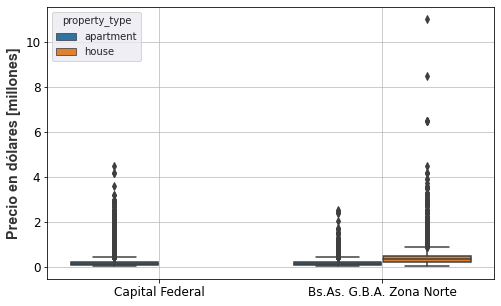

In [23]:
dims = (8,5)
fig,ax = plt.subplots(figsize=dims)#,ncols=2
with sns.axes_style('darkgrid'):
    g = sns.boxplot(x ='state_name',y = 'price_aprox_usd',hue = 'property_type' ,data=data5,
                     ax=ax)  #style='sort' linewidth=2.3,markers=True,markersize=9
    g.set_xlabel('',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Precio en dólares [millones]',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_title('Porcentaje de propiedades',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
    g.set_xticklabels(['Capital Federal','Bs.As. G.B.A. Zona Norte'],size=12)
    g.set_yticklabels(['0','2','4','6','8','10'],size=12)
    #g.legend() #bbox_to_anchor=(0.99, 0.32)
    g.grid(alpha=0.8)

Como puede observarse, la variable precio en dolares posee muchos outlier.Es por eso que se prodece a hacer una limpieza de outlier de las variables precio en dólares, precio por metro2 cubierto y metros2 cubiertos, con el fin de afinar el modelo (esto sería el paso final después de una diversa cantidad de pruebas).

In [24]:
def outliers(data):
    for x in data.codigo2.value_counts().index:
        q1 = data.loc[data.codigo2==x,"price_aprox_usd"].quantile(0.25)
        q3 = data.loc[data.codigo2==x,"price_aprox_usd"].quantile(0.75) # 7th percentile / 3rd quartile
        iqr = q3 - q1 #Interquartile range
        out1 = q1 - 1.5*iqr
        out2 = q3 + 1.5*iqr
        data.loc[(data.codigo2==x)&(data["price_aprox_usd"]>out1)&(data["price_aprox_usd"]<out2),"outlier"] = 0
    return data

In [25]:
def outliers2(data):
    for x in data.codigo2.value_counts().index:
        q1 = data.loc[data.codigo2==x,"precio_por_m2_cubiertos"].quantile(0.25)
        q3 = data.loc[data.codigo2==x,"precio_por_m2_cubiertos"].quantile(0.75) # 7th percentile / 3rd quartile
        iqr = q3 - q1 #Interquartile range
        out1 = q1 - 1.5*iqr
        out2 = q3 + 1.5*iqr
        data.loc[(data.codigo2==x)&(data["precio_por_m2_cubiertos"]>out1)&(data["precio_por_m2_cubiertos"]<out2),"outlier2"] = 0
    return data

In [26]:
def outliers3(data):
    for x in data.codigo2.value_counts().index:
        q1 = data.loc[data.codigo2==x,"m2 cubiertos"].quantile(0.25)
        q3 = data.loc[data.codigo2==x,"m2 cubiertos"].quantile(0.75) # 7th percentile / 3rd quartile
        iqr = q3 - q1 #Interquartile range
        out1 = q1 - 1.5*iqr
        out2 = q3 + 1.5*iqr
        data.loc[(data.codigo2==x)&(data["m2 cubiertos"]>out1)&(data["m2 cubiertos"]<out2),"outlier3"] = 0
    return data

In [27]:
data6 = outliers(data5)
mask = data6.outlier == 0
data7 = data6.loc[mask]

data8 = outliers2(data7)
mask2 = data8.outlier2 == 0
data9 = data8.loc[mask2]

data10 = outliers3(data9)
mask3 = data10.outlier3 == 0
data11 = data10.loc[mask3]

#data12 = data11[data11.price_aprox_usd < 1000000]

data12 = data11
data12

D:\Users\Lean\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
D:\Users\Lean\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
D:\Users\Lean\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,property_type,CiudadClean,es_country_clean,amenities,price_aprox_usd,m2 Totales,m2 cubiertos,precio_por_m2_cubiertos,precio_por_m2_total,state_name,...,villa real,villa riachuelo,villa santa rita,villa soldati,villa urquiza,Capital Federal,house,outlier,outlier2,outlier3
1,apartment,mataderos,0,0,72000.0,55.000000,55.0,1309.090909,1309.090909,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
4,apartment,belgrano,0,0,138000.0,45.000000,40.0,3450.000000,3066.666667,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
5,apartment,belgrano,0,0,195000.0,65.000000,60.0,3250.000000,3000.000000,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
6,apartment,san isidro,0,0,115000.0,39.000000,36.0,3194.444444,2948.717949,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,0,0,0,0
7,apartment,palermo,0,0,111700.0,50.000000,30.0,3723.333333,2234.000000,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86364,house,pilar,1,0,170000.0,189.865278,130.0,1307.692308,895.371719,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,1,0,0,0
86365,apartment,belgrano,0,1,128000.0,38.000000,35.0,3657.142857,3368.421053,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
86366,apartment,recoleta,0,0,165000.0,44.000000,39.0,4230.769231,3750.000000,Capital Federal,...,0,0,0,0,0,1,0,0,0,0
86369,house,san isidro,0,0,498000.0,360.000000,360.0,1383.333333,1383.333333,Bs.As. G.B.A. Zona Norte,...,0,0,0,0,0,0,1,0,0,0


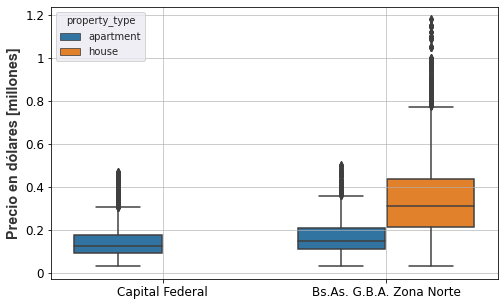

In [28]:
dims = (8,5)
fig,ax = plt.subplots(figsize=dims)#,ncols=2
with sns.axes_style('darkgrid'):
    g = sns.boxplot(x ='state_name',y = 'price_aprox_usd',hue = 'property_type' ,data=data12,
                     ax=ax)  #style='sort' linewidth=2.3,markers=True,markersize=9
    g.set_xlabel('',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Precio en dólares [millones]',weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    #g.set_title('Porcentaje de propiedades',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,200000,400000,600000,800000,1000000,1200000])
    g.set_xticklabels(['Capital Federal','Bs.As. G.B.A. Zona Norte'],size=12)
    g.set_yticklabels(['0','0.2','0.4','0.6','0.8','1','1.2'],size=12)
    #g.legend() #bbox_to_anchor=(0.99, 0.32)
    g.grid(alpha=0.8)

Una vez hecho esto, se prodece a quedarnos con las variables cuantitatitativas y dummies y se realiza el featured scalling para mejorar la performance del modelo. También, se eliminan los barrios que poseen pocas muestras y valores de p-valor muy elevados (los cuales fueron chequeados con statsmodel). Nuevamente, esto es el paso final de una serie de pruebas.

In [29]:
X = data12.drop(['property_type','CiudadClean',"price_aprox_usd",'m2 Totales',
                'precio_por_m2_cubiertos',"precio_por_m2_total",'state_name','codigo2','outlier',
                'outlier2','outlier3'], axis=1)

barrios = ['agronomía', 'versalles', 'pompeya', 'velez sarsfield', 'villa real', 'villa soldati', 'villa riachuelo', 
           'catalinas','balvanera','boca','boedo','centro / microcentro',
           'chacarita','congreso','flores','floresta','liniers',
           'mataderos','monserrat','monte castro','once','parque avellaneda',
           'parque chacabuco','parque chas','parque patricios','paternal','san cristobal',
           'san nicolás','san telmo','tribunales',
           'villa general mitre','villa ortuzar','villa pueyrredón',
           'villa santa rita','Capital Federal','barracas','villa del parque','parque centenario']


#barrios = ['agronomía', 'versalles', 'pompeya', 'velez sarsfield', 'villa real', 'villa soldati', 'villa riachuelo', 'catalinas']

X = X.drop(barrios, axis = 1)

X['m2_cub_2']  = X['m2 cubiertos']**2 

X['m2_cub_3']  = X['m2 cubiertos']**3

X['m2_cub_4']  = X['m2 cubiertos']**4

X['prop_cubierto_2'] = X['prop_cubierto']**2    


y = data12.loc[:,['price_aprox_usd']]

#plt.scatter(data12['m2 cubiertos'], data12.price_aprox_usd)
print(X.shape)
print(y.shape)

X.columns

(37253, 38)
(37253, 1)


Index(['es_country_clean', 'amenities', 'm2 cubiertos', 'prop_cubierto',
       'almagro', 'barrio norte', 'belgrano', 'caballito', 'coghlan',
       'colegiales', 'constitución', 'escobar', 'general san martín',
       'josé c paz', 'las cañitas', 'malvinas argentinas', 'nuñez', 'palermo',
       'pilar', 'puerto madero', 'recoleta', 'retiro', 'saavedra',
       'san fernando', 'san isidro', 'san miguel', 'tigre', 'vicente lópez',
       'villa crespo', 'villa devoto', 'villa lugano', 'villa luro',
       'villa urquiza', 'house', 'm2_cub_2', 'm2_cub_3', 'm2_cub_4',
       'prop_cubierto_2'],
      dtype='object')

<a id="section_traintestsplit"></a> 
## Train-Test-Split

[volver a TOC](#section_toc)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 117) 

<a id="section_instanciar"></a> 
## Instanciar el modelo

[volver a TOC](#section_toc)

In [31]:
from sklearn import linear_model

model = linear_model.LinearRegression()

modelo = model.fit(X_train,y_train)

modelo.score(X_train, y_train)

0.8120590699726473

<a id="section_r2_train"></a> 
## Cálculo de métricas de error para Train

[volver a TOC](#section_toc)

In [32]:
y_pred_train = modelo.predict(X_train)
y_pred_train.shape

(26077, 1)

In [33]:
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y_train_std = scaler.fit_transform(y_train)

y_pred_train_std = scaler.fit_transform(y_pred_train)

print('Mean Absolute Error',mean_absolute_error(y_train, y_pred_train).round(2))
print('Mean Squared Error',mean_squared_error(y_train, y_pred_train).round(2))
print('R2 scored', r2_score(y_train, y_pred_train),'\n')

print('Normalizer \n')

print('Mean Absolute Error',mean_absolute_error(y_train_std, y_pred_train_std))
print('Mean Squared Error',mean_squared_error(y_train_std, y_pred_train_std))
print('R2 scored', r2_score(y_train_std, y_pred_train_std))

Mean Absolute Error 40613.64
Mean Squared Error 3841972388.7
R2 scored 0.8120590699726473 

Normalizer 

Mean Absolute Error 0.29709312960979545
Mean Squared Error 0.19771359659720053
R2 scored 0.8022864034027994


<a id="section_stats"></a> 
## Análisis de p-value para las variables predictoras

[volver a TOC](#section_toc)

In [34]:
# Importamos la api.
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Tenemos que agregar explícitamente a una constante:
X_sm = sm.add_constant(X_train)

model2 = sm.OLS(y_train, X_sm).fit()
predictions = model2.predict(X_sm)

# Graficamos los resultados
#plt.plot(y_train,y_train, '-.', c='grey')
#plt.scatter(y_train,predictions, s=30, c='r', marker='+', zorder=10)
#plt.xlabel("valores reales")
#plt.ylabel("predicciones")
#plt.show()


print (model2.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     2961.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:09:43   Log-Likelihood:            -3.2475e+05
No. Observations:               26077   AIC:                         6.496e+05
Df Residuals:                   26038   BIC:                         6.499e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.694e+04   4

<a id="section_graf"></a> 
## Gráfico de la predicción

[volver a TOC](#section_toc)

A continuación, se prodece una recta de la variable target consigo mismo, y la predicción vs los valores reales, co el fin de observar visualmente que tan cerca están los datos predichos con la recta ideal.

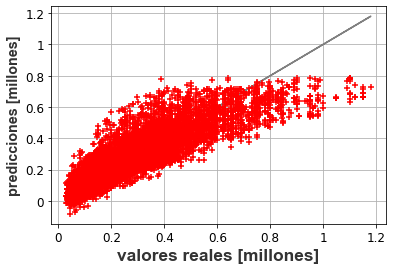

In [35]:
plt.plot(y_train,y_train, '-', c='grey')
plt.scatter(y_train,predictions, s=30, c='r', marker='+', zorder=10)
plt.xlabel("valores reales [millones]",weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.ylabel("predicciones [millones]",weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.xticks([0,200000,400000,600000,800000,1000000,1200000],labels = ['0','0.2','0.4','0.6','0.8','1','1.2'],
           size=12)
plt.yticks([0,200000,400000,600000,800000,1000000,1200000],labels = ['0','0.2','0.4','0.6','0.8','1','1.2'],
           size=12)
plt.grid()
plt.show()

<a id="section_test_metrics"></a> 
## Cálculo de métricas de error (Test)

[volver a TOC](#section_toc)

In [36]:
y_pred_test = modelo.predict(X_test)
y_pred_test.shape

(11176, 1)

In [37]:
scaler = StandardScaler()

y_test_std = scaler.fit_transform(y_test)

y_pred_test_std = scaler.fit_transform(y_pred_test)

print('Mean Absolute Error',mean_absolute_error(y_test, y_pred_test).round(2))
print('Mean Squared Error',mean_squared_error(y_test, y_pred_test).round(2))
print('R2 scored', r2_score(y_test, y_pred_test),'\n')

print('Normalizer \n')

print('Mean Absolute Error',mean_absolute_error(y_test_std, y_pred_test_std))
print('Mean Squared Error',mean_squared_error(y_test_std, y_pred_test_std))
print('R2 scored', r2_score(y_test_std, y_pred_test_std))

#modelo.score(X_test,y_test)

Mean Absolute Error 40977.79
Mean Squared Error 3883420501.31
R2 scored 0.8092831361791385 

Normalizer 

Mean Absolute Error 0.2998606226551948
Mean Squared Error 0.20076153133744679
R2 scored 0.7992384686625532


<a id="section_ridge"></a> 
## Regresion Ridge

[volver a TOC](#section_toc)


<a id="section_norm"></a> 
### Normalización

[volver a TOC](#section_toc)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y_std = scaler.fit_transform(y)

<a id="section_train_test_norm"></a> 
### Train-Test Split Normalized

[volver a TOC](#section_toc)

In [39]:
X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_std, y_std, 
                                                                            test_size = 0.3, random_state = 117)

<a id="section_fit_ridge"></a> 
### Fit Regression with Regularization and Cross_Validation

[volver a TOC](#section_toc)

In [40]:
model_ridge_cv = linear_model.RidgeCV(alphas= [13.001, 13.002, 13.003, 13.004, 13.005, 13.006,
                                               13.007, 13.008, 13.009, 13.48, 13.49,
                                               13.5, 13.51, 13.01, 14], #10.52
                                                normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train_Ridge, y_train_Ridge)

print(model_fit_ridge_cv.alpha_)

print(model_fit_ridge_cv.best_score_)

13.001
0.8090755630061462


In [41]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, normalize = False)
model_fit_ridge = model_ridge.fit(X_train_Ridge, y_train_Ridge)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print('R2 score',model_fit_ridge.score(X_train_Ridge, y_train_Ridge))

[[ 0.08647765  0.03365117  1.55415477  0.11498914  0.01043363  0.04120667
   0.07578651  0.03922143  0.01436276  0.02033329 -0.00640693 -0.06260005
  -0.04680875 -0.02088464  0.02231888 -0.02876364  0.04289872  0.09374774
  -0.05609685  0.02902678  0.06495362  0.00753971  0.01761104  0.01538163
   0.05825109 -0.04804547  0.10715448  0.07644236  0.02773277  0.00949503
  -0.01485005  0.00600623  0.03390676 -0.25887218 -0.79264431  0.16657712
   0.13854435 -0.1611072 ]]
[-0.00085628]
R2 score 0.809906277568375


<a id="section_error_ridge_train"></a> 
### Metricas de Error (Train)

[volver a TOC](#section_toc)



In [42]:
y_pred_train_ridge = model_fit_ridge_cv.predict(X_train_Ridge)
y_pred_train_ridge.shape

(26077, 1)

In [43]:
print('Mean Absolute Error',mean_absolute_error(y_train_Ridge, y_pred_train_ridge))
print('Mean Squared Error',mean_squared_error(y_train_Ridge, y_pred_train_ridge))
print('R2 scored', r2_score(y_train_Ridge, y_pred_train_ridge))

Mean Absolute Error 0.28517241770256013
Mean Squared Error 0.19031745706271164
R2 scored 0.809906277568375


<a id="section_graf_ridge"></a> 
### Gráfico de la predicción

[volver a TOC](#section_toc)

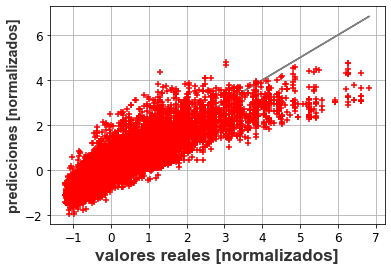

In [44]:
plt.plot(y_train_Ridge,y_train_Ridge, '-', c='grey')
plt.scatter(y_train_Ridge,y_pred_train_ridge, s=30, c='r', marker='+', zorder=10)
plt.xlabel("valores reales [normalizados]",weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.ylabel("predicciones [normalizados]",weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

<a id="section_error_ridge_test"></a> 
### Metricas de Error (Test)

[volver a TOC](#section_toc)

In [45]:
y_pred_test_ridge = model_fit_ridge.predict(X_test_Ridge)
y_pred_test_ridge.shape

(11176, 1)

In [46]:
print('Mean Absolute Error',mean_absolute_error(y_test_Ridge, y_pred_test_ridge))
print('Mean Squared Error',mean_squared_error(y_test_Ridge, y_pred_test_ridge))
print('R2 scored', r2_score(y_test_Ridge, y_pred_test_ridge))

Mean Absolute Error 0.2877930723936954
Mean Squared Error 0.19186432510850285
R2 scored 0.8076062655715541


<a id="section_lasso"></a> 
## Lasso

[volver a TOC](#section_toc)

<a id="section_lasso_train_test_split"></a> 
### Train Test Split

[volver a TOC](#section_toc)

In [47]:
X_train_Lasso, X_test_Lasso, y_train_Lasso, y_test_Lasso = train_test_split(X_std, y_std, test_size = 0.3,
                                                                            random_state = 117)

<a id="section_lasso_fit"></a> 
### Fit model with Cross Validation

[volver a TOC](#section_toc)


In [48]:
model_lasso_cv = linear_model.LassoCV(alphas= [0.001, 0.02, 0.05, 0.08, 0.09, 0.95, 0.97, 0.1, 
                                               0.12, 0.15, 0.2, 0.3, 1.0, 10.0],
                                      normalize=False, cv=10, max_iter=1e4)

model_fit_lasso_cv = model_lasso_cv.fit(X_train_Lasso, y_train_Lasso)

print(model_fit_lasso_cv.alpha_)

print(model_fit_lasso_cv.score(X_train_Lasso, y_train_Lasso))

D:\Users\Lean\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.001
0.8091782941988074


In [49]:
best_alpha = model_fit_lasso_cv.alpha_
model_lasso = linear_model.Lasso(alpha = best_alpha, normalize = False)
model_fit_lasso = model_lasso.fit(X_train_Lasso, y_train_Lasso)
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)

[ 0.08540072  0.0338293   1.43467861  0.06795392  0.00789096  0.039155
  0.07314241  0.03655159  0.01270151  0.0187161  -0.00635135 -0.06291777
 -0.04633414 -0.02008336  0.02077516 -0.02881921  0.04123996  0.0907194
 -0.05683962  0.02759013  0.06291783  0.00604625  0.01601968  0.0139639
  0.05706035 -0.04874306  0.10417734  0.07504465  0.02498468  0.00796512
 -0.01418239  0.00431548  0.03145447 -0.25944198 -0.52858928  0.
  0.15209538 -0.11485269]
[-0.00077746]


<a id="section_lasso_error_train"></a> 
### Métricas de Error (Train)

[volver a TOC](#section_toc)



In [50]:
y_pred_train_lasso = model_fit_lasso.predict(X_train_Lasso)
y_pred_train_lasso = y_pred_train_lasso.reshape(-1,1)
y_pred_train_lasso.shape

(26077, 1)

In [51]:
print('Mean Absolute Error',mean_absolute_error(y_train_Lasso, y_pred_train_lasso))
print('Mean Squared Error',mean_squared_error(y_train_Lasso, y_pred_train_lasso))
print('R2 scored', r2_score(y_train_Lasso, y_pred_train_lasso))

Mean Absolute Error 0.28578749543377857
Mean Squared Error 0.1910462972469523
R2 scored 0.8091782941988074


<a id="section_graf_lasso"></a> 
### Gráfico de la predicción

[volver a TOC](#section_toc)





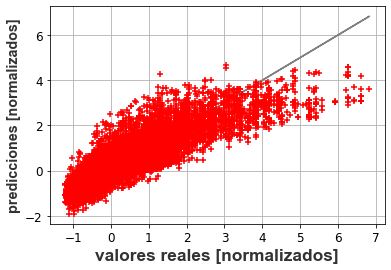

In [52]:
plt.plot(y_train_Lasso,y_train_Lasso, '-', c='grey')
plt.scatter(y_train_Lasso,y_pred_train_lasso, s=30, c='r', marker='+', zorder=10)
plt.xlabel("valores reales [normalizados]",weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.ylabel("predicciones [normalizados]",weight='bold',size='x-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

<a id="section_error_ridge_test"></a> 
### Metricas de Error (Test)

[volver a TOC](#section_toc)


In [53]:
y_pred_test_lasso = model_fit_lasso.predict(X_test_Lasso)
y_pred_test_lasso = y_pred_test_lasso.reshape(-1,1)
y_pred_test_lasso.shape

(11176, 1)

In [54]:
print('Mean Absolute Error',mean_absolute_error(y_test_Lasso, y_pred_test_lasso))
print('Mean Squared Error',mean_squared_error(y_test_Lasso, y_pred_test_lasso))
print('R2 scored', r2_score(y_test_Lasso, y_pred_test_lasso))

Mean Absolute Error 0.2885361685244728
Mean Squared Error 0.1926728880394587
R2 scored 0.806795471580962
